In [1]:
import os, sys
from IPython.display import display, HTML, Markdown, Math, Latex
import pandas as pd
import numpy as np
import sympy as sym
from scipy.stats import norm
import math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz,  beautify

In [2]:
%%capture
%mkdir -p ~/temp
%cd ~/temp

In [3]:
def bmatrix(a): # bmatrix esta sacada de: https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
    """Returns a LaTeX bmatrix
    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    a = a.values
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

# Enunciado

Utilizando los valores que se proporcionan de la duración de las actividades, se pide:

In [4]:
pregunta_1 = Markdown("1.- Dibujar el grafo PERT y determinar el cuadro de ancestros (prelaciones transitivas)  ")
pregunta_2 = Markdown("2.- Determinar la matriz de caminos del proyecto  ")
pregunta_3 = Markdown("3.- Utilizar la matriz de caminos del proyecto para calcular su duración  ")
pregunta_4 = Markdown("4.- Calcular la duración para probabilidad 95% de fin de proyecto utilizando la ley de distribución normal  ")
pregunta_5 = Markdown("5.- Calcular la duración para probabilidad 95% de fin de proyecto utilizando los resultados numéricos obtenidos en las distintas iteraciones del método de MonteCarlo  ")

In [5]:
for item in dir():
    if item.startswith('pregunta_'):
        display(eval(item))

1.- Dibujar el grafo PERT y determinar el cuadro de ancestros (prelaciones transitivas)  

2.- Determinar la matriz de caminos del proyecto  

3.- Utilizar la matriz de caminos del proyecto para calcular su duración  

4.- Calcular la duración para probabilidad 95% de fin de proyecto utilizando la ley de distribución normal  

5.- Calcular la duración para probabilidad 95% de fin de proyecto utilizando los resultados numéricos obtenidos en las distintas iteraciones del método de MonteCarlo  

In [6]:
duraciones=pd.DataFrame.from_records([
( 8.747,  13.512,   7.919,  6.359,  8.835,  8.398,  10.201,  4.238,  1.716),
(10.367,  12.390,   7.782,  4.897,  8.747,  7.388,   8.980,  3.645,  1.932),
( 8.329,  11.379,   7.075,  5.388,  9.697,  8.341,   9.345,  4.305,  2.589),
(13.191,   9.785,   5.011,  4.946,  9.557,  6.871,   9.014,  3.533,  1.238),
(10.659,  13.125,   7.620,  3.623,  8.311,  9.433,   8.628,  3.373,  2.297),
( 8.359,  11.955,   6.944,  4.585,  8.293,  9.980,   9.094,  4.146,  2.166),
(10.975,  11.984,   6.844,  4.606,  9.365,  7.633,   8.098,  3.778,  2.532),
(11.477,  12.944,   5.529,  4.941,  9.769,  6.956,   9.733,  4.001,  1.848),
(11.152,  12.821,   6.522,  6.100,  8.888,  8.570,   9.077,  4.037,  2.185),
( 9.389,  12.594,   7.418,  5.763,  9.881,  7.865,  10.086,  3.705,  2.134)
], columns=list('ABCDEFGHI'))


datos_enunciado = pd.DataFrame()
datos_enunciado['predecesoras'] = {
    "A": "---  ",
    "B": "---  ",
    "C": "---  ",
    "D": "A    ",
    "E": "B    ",
    "F": "C,D,E",
    "G": "A    ",
    "H": "B    ",
    "I": "F    ",
}
datos_enunciado.index.name='actividad'
proyecto = ProjectGraph.from_dict_of_strings(datos_enunciado['predecesoras'])

In [7]:
#| tbl-cap: "Cuadro de datos del enunciado del ejercicio"
#| label: tbl-datosEnunciado
pd.concat([datos_enunciado, duraciones.T], axis=1)

,predecesoras,0,1,2,3,4,5,6,7,8,9
A,---,8.747,10.367,8.329,13.191,10.659,8.359,10.975,11.477,11.152,9.389
B,---,13.512,12.390,11.379,9.785,13.125,11.955,11.984,12.944,12.821,12.594
C,---,7.919,7.782,7.075,5.011,7.620,6.944,6.844,5.529,6.522,7.418
D,A,6.359,4.897,5.388,4.946,3.623,4.585,4.606,4.941,6.100,5.763
E,B,8.835,8.747,9.697,9.557,8.311,8.293,9.365,9.769,8.888,9.881
F,"C,D,E",8.398,7.388,8.341,6.871,9.433,9.980,7.633,6.956,8.570,7.865
G,A,10.201,8.980,9.345,9.014,8.628,9.094,8.098,9.733,9.077,10.086
H,B,4.238,3.645,4.305,3.533,3.373,4.146,3.778,4.001,4.037,3.705
I,F,1.716,1.932,2.589,1.238,2.297,2.166,2.532,1.848,2.185,2.134


# Resolución:
## Apartado 1

In [8]:
display(pregunta_1)

1.- Dibujar el grafo PERT y determinar el cuadro de ancestros (prelaciones transitivas)  

### Cuadros de prelaciones expandido

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.

In [9]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto,
                                                         activity='actividad',
                                                         predecessor='predecesoras')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I
activities,,,,,,,,,
A,,,,,,,,,
B,,,,,,,,,
C,,,,,,,,,
D,True,,,,,,,,
E,,True,,,,,,,
F,,,True,True,True,,,,
G,True,,,,,,,,
H,,True,,,,,,,
I,,,,,,True,,,


### Grafo PERT con numeración de nodos

Utilizando el cuadro de prelaciones expandido podemos dibujar el grafo Pert correspondiente al proyecto.

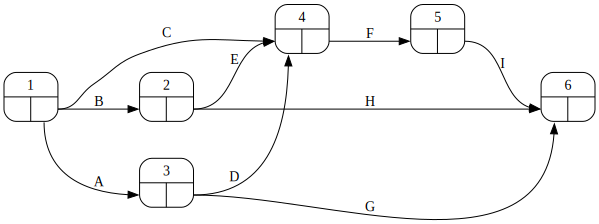

In [10]:
#| fig-cap: "Grafo Pert con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto.pert(durations=False, ranksep=1)

In [11]:
#| tbl-cap: "Cuadro de ancestros (prelaciones transitivas)"
#| label: tbl-CuadroAncestros
proyecto.distant_predecessor(format='DataFrame')

,predecessors
A,----
B,----
C,----
D,A
E,B
F,"A, B, C, D, E"
G,A
H,B
I,"A, B, C, D, E, F"


## Apartado 2

In [12]:
display(pregunta_2)

2.- Determinar la matriz de caminos del proyecto  

In [13]:
#| tbl-cap: "Matriz de rutas"
#| label: tbl-MatrixRutas
proyecto.display_path_matrix(dummies=False)

,A,B,C,D,E,F,G,H,I
Route_1,1,0,0,1,0,1,0,0,1
Route_2,1,0,0,0,0,0,1,0,0
Route_3,0,1,0,0,1,1,0,0,1
Route_4,0,1,0,0,0,0,0,1,0
Route_5,0,0,1,0,0,1,0,0,1


## Apartado 3

In [14]:
display(pregunta_3)

3.- Utilizar la matriz de caminos del proyecto para calcular su duración  

Multiplicando la matriz de rutas con las duraciones de las actividades, se obtienen la duración de las rutas en cada iteración:

In [15]:
path_matrix = proyecto.path_matrix(dummies=False)
D = duraciones.T
duraciones_de_caminos = (path_matrix @ D)

In [16]:
# LaTex for pretty print, the calculations are already done
Math(  bmatrix(path_matrix) + " \\times " + bmatrix(D) + " = " + bmatrix(duraciones_de_caminos) )

<IPython.core.display.Math object>

Las duraciones de las rutas son entonces:

In [17]:
#| tbl-cap: "Duraciones de las rutas en cada iteración"
#| label: tbl-DuracionesCaminos
duraciones_de_caminos

,0,1,2,3,4,5,6,7,8,9
Route_1,25.220,24.584,24.647,26.246,26.012,25.090,25.746,25.222,28.007,25.151
Route_2,18.948,19.347,17.674,22.205,19.287,17.453,19.073,21.210,20.229,19.475
Route_3,32.461,30.457,32.006,27.451,33.166,32.394,31.514,31.517,32.464,32.474
Route_4,17.750,16.035,15.684,13.318,16.498,16.101,15.762,16.945,16.858,16.299
Route_5,18.033,17.102,18.005,13.120,19.350,19.090,17.009,14.333,17.277,17.417


La duración del proyecto se obtiene, en cada iteración, como el máximo de las duraciones de las rutas:

In [18]:
#| tbl-cap: "Duraciones del proyecto en cada iteración"
#| label: tbl-DuracionesProyecto
duraciones_de_proyecto = duraciones_de_caminos.max(axis="rows").to_frame(name='Duración proyecto')
duraciones_de_proyecto.T

,0,1,2,3,4,5,6,7,8,9
Duración proyecto,32.461,30.457,32.006,27.451,33.166,32.394,31.514,31.517,32.464,32.474


In [19]:
#| tbl-cap: "Cuadro resumen de descriptores estadísticos de la duración del proyecto"
#| label: tbl-DescriptoresEstadisticos
duraciones_de_proyecto.describe().round(2)

,Duración proyecto
count,10.00
mean,31.59
std,1.63
min,27.45
25%,31.51
50%,32.20
75%,32.46
max,33.17


In [20]:
media_duracion_proyecto = duraciones_de_proyecto.mean().iloc[0]
desviacion_tipica=duraciones_de_proyecto.std().iloc[0]
print(f'La duración media del proyecto es {media_duracion_proyecto:.2f} y la desviación típica es {desviacion_tipica:.2f}')

La duración media del proyecto es 31.59 y la desviación típica es 1.63


## Apartado 4

In [21]:
display(pregunta_4)

4.- Calcular la duración para probabilidad 95% de fin de proyecto utilizando la ley de distribución normal  

In [22]:
from scipy.stats import norm

In [23]:
percentil = 0.95
duracion_para_percentil = round(norm.ppf(percentil, loc=media_duracion_proyecto, scale=desviacion_tipica), 2)
Markdown(f'Si utilizamos la ley normal de distribución, para una duración media {round(media_duracion_proyecto, 2)} y desviación típica {round(desviacion_tipica,2)} la duración para probabilidad igual a {percentil*100} por ciento es {duracion_para_percentil} periodos')

Si utilizamos la ley normal de distribución, para una duración media 31.59 y desviación típica 1.63 la duración para probabilidad igual a 95.0 por ciento es 34.28 periodos

## Apartado 5

In [24]:
display(pregunta_5)

5.- Calcular la duración para probabilidad 95% de fin de proyecto utilizando los resultados numéricos obtenidos en las distintas iteraciones del método de MonteCarlo  

In [25]:
duracion_para_percentil_montecarlo =round(float(duraciones_de_proyecto.quantile(percentil).iloc[0]),2)

In [26]:
Markdown(f'Si utilizamos la colección de resultados del método de MonteCarlo, la duración para el cuantil {percentil*100} por ciento es {duracion_para_percentil_montecarlo} periodos.')

Si utilizamos la colección de resultados del método de MonteCarlo, la duración para el cuantil 95.0 por ciento es 32.85 periodos.